### Human vs Horse detector - Training with ImageDataGenerator and image modification

In this project a model will be trained which will differentiate an image between whether it is a horse or a person. There are 1000 images for training and 256 for validation with different sizes and positions.

Here we explicitly do not have a label for each image, so we will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) API instead. and it will automatically do the label for us.

In addition, a modification will also be used in the input images, which will be rotated, zoomed, etc., in order to have a better response from the model.

In [1]:
import zipfile

# Unzip the dataset for Train and Validation
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')


# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

In [2]:
import os

# Directory the datasets
train_horse_dir = os.path.join('./horse-or-human/horses')

train_human_dir = os.path.join('./horse-or-human/humans')

validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

validation_human_dir = os.path.join('./validation-horse-or-human/humans')

Below are some names of the images grouped in the different training and validation sets.

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:5]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:5]}')

validation_horse_names = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:5]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:5]}')

TRAIN SET HORSES: ['horse18-7.png', 'horse27-2.png', 'horse50-7.png', 'horse44-6.png', 'horse44-7.png']
TRAIN SET HUMANS: ['human17-30.png', 'human17-02.png', 'human11-10.png', 'human17-29.png', 'human09-14.png']
VAL SET HORSES: ['horse5-478.png', 'horse5-360.png', 'horse6-161.png', 'horse1-298.png', 'horse2-040.png']
VAL SET HUMANS: ['valhuman05-21.png', 'valhuman03-22.png', 'valhuman01-06.png', 'valhuman04-22.png', 'valhuman05-12.png']


In total there are a number of images of:

In [4]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


A sample of the type of images used in this project is shown below.

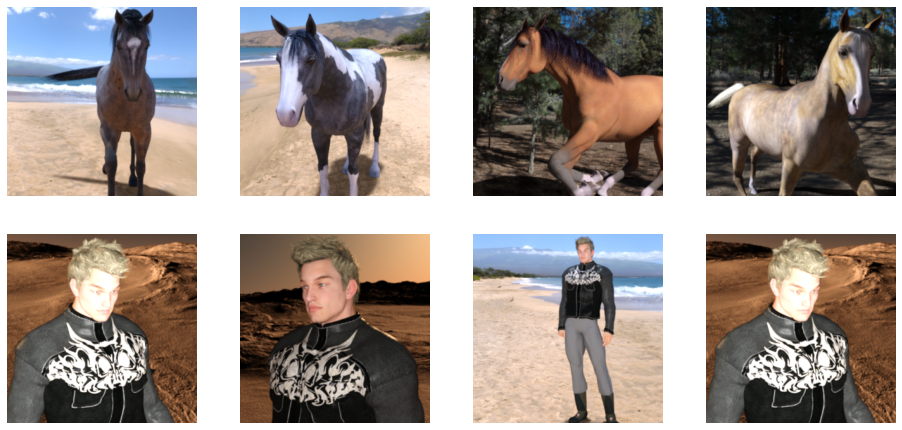

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-4:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Convolutional Model

As a model, a convolutional network will be used, which will work together with different pooling layers.

In [6]:
import tensorflow as tf

In [25]:
model = tf.keras.Sequential([
    # te disired size is 150 x 150 and in color(3)
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

The "output shape" column shows how the size of your feature map evolves in each successive layer. Here you see how the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.


# PRE PROCESSING

Next, the *generator* is used to resize all the images in a size of 300x300 and place their respective label (horse or human). An additional process will be to normalize the images so that the pixel values ​​are between [0,1]


In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  
        target_size=(150, 150),  
        batch_size=128,
        # Since you use binary_crossentropy loss,need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/', 
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## OPTIMIZER

In order to find the best learning rate for the model, a comparison is made between different loss values with different learning rates, looking for the one that provides the least value.

In [10]:
from tensorflow.keras.optimizers import RMSprop

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = RMSprop(learning_rate=1e-8)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=120,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[lr_schedule])


Epoch 1/120
8/8 [==============================] - 11s 1s/step - loss: 0.7056 - accuracy: 0.4850 - val_loss: 0.7090 - val_accuracy: 0.5000 - lr: 1.0000e-08
Epoch 2/120
8/8 [==============================] - 11s 1s/step - loss: 0.7059 - accuracy: 0.4794 - val_loss: 0.7089 - val_accuracy: 0.5000 - lr: 1.1220e-08
Epoch 3/120
8/8 [==============================] - 11s 1s/step - loss: 0.7031 - accuracy: 0.4950 - val_loss: 0.7088 - val_accuracy: 0.5000 - lr: 1.2589e-08
Epoch 4/120
8/8 [==============================] - 11s 1s/step - loss: 0.7042 - accuracy: 0.4863 - val_loss: 0.7087 - val_accuracy: 0.5000 - lr: 1.4125e-08
Epoch 5/120
8/8 [==============================] - 11s 1s/step - loss: 0.7028 - accuracy: 0.4872 - val_loss: 0.7085 - val_accuracy: 0.5000 - lr: 1.5849e-08
Epoch 6/120
8/8 [==============================] - 11s 1s/step - loss: 0.7042 - accuracy: 0.4861 - val_loss: 0.7084 - val_accuracy: 0.5000 - lr: 1.7783e-08
Epoch 7/120
8/8 [==============================] - 11s 1s/step -

8/8 [==============================] - 13s 2s/step - loss: 0.4266 - accuracy: 0.7942 - val_loss: 3.1228 - val_accuracy: 0.5430 - lr: 0.0016
Epoch 106/120
8/8 [==============================] - 12s 1s/step - loss: 0.4718 - accuracy: 0.8120 - val_loss: 0.8838 - val_accuracy: 0.6914 - lr: 0.0018
Epoch 107/120
8/8 [==============================] - 11s 2s/step - loss: 0.5349 - accuracy: 0.7497 - val_loss: 2.8547 - val_accuracy: 0.6445 - lr: 0.0020
Epoch 108/120
8/8 [==============================] - 11s 2s/step - loss: 0.5273 - accuracy: 0.7586 - val_loss: 3.5299 - val_accuracy: 0.5273 - lr: 0.0022
Epoch 109/120
8/8 [==============================] - 12s 1s/step - loss: 1.3751 - accuracy: 0.6274 - val_loss: 0.5365 - val_accuracy: 0.5586 - lr: 0.0025
Epoch 110/120
8/8 [==============================] - 12s 1s/step - loss: 0.6285 - accuracy: 0.6374 - val_loss: 0.3958 - val_accuracy: 0.8398 - lr: 0.0028
Epoch 111/120
8/8 [==============================] - 11s 1s/step - loss: 0.5496 - accuracy

(1e-09, 0.1, 0.0, 2.0)

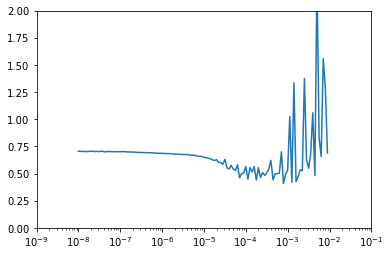

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e-1, 0, 2])

### MODEL

In [27]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=105,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/105
8/8 [==============================] - 13s 1s/step - loss: 0.6893 - accuracy: 0.5284 - val_loss: 0.7050 - val_accuracy: 0.5000
Epoch 2/105
8/8 [==============================] - 12s 1s/step - loss: 0.6787 - accuracy: 0.5295 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 3/105
8/8 [==============================] - 12s 1s/step - loss: 0.6807 - accuracy: 0.5451 - val_loss: 0.6587 - val_accuracy: 0.6445
Epoch 4/105
8/8 [==============================] - 13s 2s/step - loss: 0.6757 - accuracy: 0.5762 - val_loss: 0.6468 - val_accuracy: 0.8359
Epoch 5/105
8/8 [==============================] - 13s 2s/step - loss: 0.6652 - accuracy: 0.5918 - val_loss: 0.6478 - val_accuracy: 0.6133
Epoch 6/105
8/8 [==============================] - 12s 1s/step - loss: 0.6536 - accuracy: 0.6908 - val_loss: 0.6328 - val_accuracy: 0.8477
Epoch 7/105
8/8 [==============================] - 12s 1s/step - loss: 0.6507 - accuracy: 0.6819 - val_loss: 0.6481 - val_accuracy: 0.5352
Epoch 8/105
8/8 [==========

<Figure size 432x288 with 0 Axes>

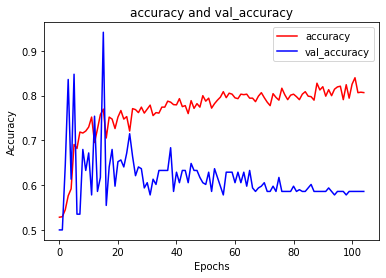

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']


epochs=range(len(val_accuracy)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')

plt.title('accuracy and val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["accuracy", "val_accuracy"])

plt.figure()


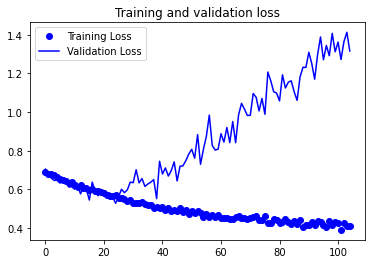

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

#plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Below you can see how the characteristics of each image vary

1/1 [==============================] - 0s 71ms/step


<ipython-input-30-ff1447792917>:45: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


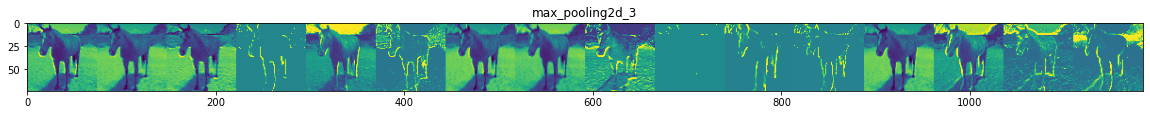

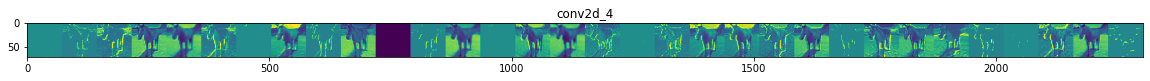

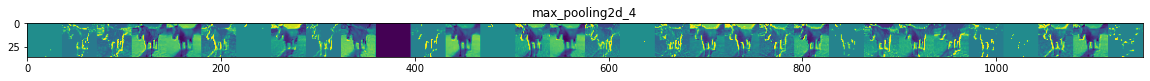

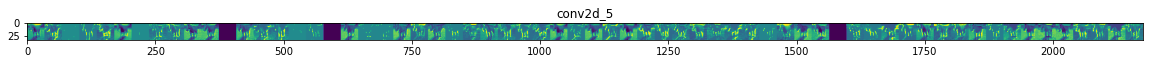

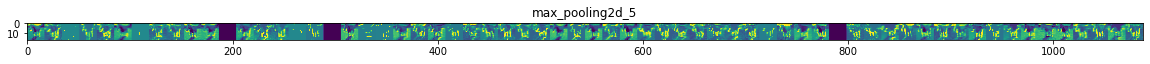

In [30]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In order to evaluate the model, the image below is passed through the model and as can be seen, it was correctly classified.

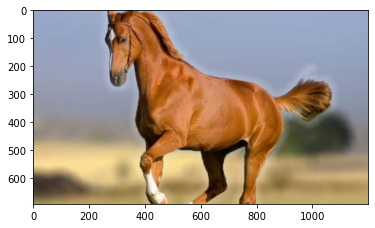

In [22]:
path = 'da.jpg' 
img = mpimg.imread(path)
plt.imshow(img)

In [31]:
import numpy as np
#from google.colab import files
from keras.preprocessing import image

# predicting images
path = 'da.jpg' 
img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])

if classes[0]>0.5:
    print(path + " is a human")
else:
    print(path + " is a horse")

1/1 [==============================] - 0s 74ms/step
[0.18337803]
da.jpg is a horse


In [33]:
import numpy as np
#from google.colab import files
from keras.preprocessing import image

# predicting images
path = 'horse.jpeg' 
img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])

if classes[0]>0.5:
    print(path + " is a human")
else:
    print(path + " is a horse")

1/1 [==============================] - 0s 23ms/step
[0.5432022]
horse.jpeg is a human
